In [1]:
import pandas as pd
train_df = pd.read_csv('train_dataset2.csv')
X_train_data = train_df.iloc[:, 1].values
y_train = train_df.iloc[:, 2].values

In [2]:
val_df = pd.read_csv('val_dataset2.csv')
X_val_data = val_df.iloc[:, 1].values
y_val = val_df.iloc[:, 2].values

In [3]:
test_df = pd.read_csv('test_dataset2.csv')
X_test_data = test_df.iloc[:, 1].values
y_test = test_df.iloc[:, 2].values

In [5]:
import numpy as np
print(np.bincount(y_train))
print(np.bincount(y_val))
print(np.bincount(y_test))

[2866  605 1684  720]
[405  86 238 102]
[824 174 484 206]


In [6]:
from konlpy.tag import Okt
from tqdm import tqdm

In [7]:
okt = Okt()

In [8]:
X_train = []
for sentence in tqdm(X_train_data):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    X_train.append(tokenized_sentence)

100%|██████████████████████████████████████████████████████████████████████████████| 5875/5875 [03:47<00:00, 25.87it/s]


In [9]:
X_val = []
for sentence in tqdm(X_val_data):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    X_val.append(tokenized_sentence)

100%|████████████████████████████████████████████████████████████████████████████████| 831/831 [00:29<00:00, 28.22it/s]


In [10]:
X_test = []
for sentence in tqdm(X_test_data):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    X_test.append(tokenized_sentence)

100%|██████████████████████████████████████████████████████████████████████████████| 1688/1688 [01:08<00:00, 24.77it/s]


In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_val)
tokenizer.fit_on_texts(X_test)

In [14]:
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)

In [15]:
vocab_size = len(tokenizer.word_index)+1 # 단어의 수
vocab_size

18256

In [22]:
print('최대 길이 :',max(len(review) for review in X_train))
print('평균 길이 :',sum(map(len, X_train))/len(X_train))


최대 길이 : 898
평균 길이 : 206.52425531914895


In [23]:
print('최대 길이 :',max(len(review) for review in X_val))
print('평균 길이 :',sum(map(len, X_val))/len(X_val))

최대 길이 : 738
평균 길이 : 202.46690734055355


In [16]:
X_train = pad_sequences(X_train, maxlen=700)
X_val = pad_sequences(X_val, maxlen=700)
X_test = pad_sequences(X_test, maxlen=700)

In [70]:
embedding_dim = 512 # 임베딩 벡터의 차원
dropout_ratio = 0.5 # 드롭아웃 비율
num_filters = 256 # 커널의 수
kernel_size = 5 # 커널의 크기
hidden_units = 128 # 뉴런의 수

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Dropout(dropout_ratio))
model.add(Conv1D(num_filters, kernel_size, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_units, activation='relu'))
model.add(Dropout(dropout_ratio))
model.add(Dense(4, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('multi_model_5.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=[es, mc])

Epoch 1/10
184/184 [==============================] - ETA: 0s - loss: 1.1844 - acc: 0.5031
Epoch 00001: val_acc improved from -inf to 0.57040, saving model to multi_model_5.h5
184/184 [==============================] - 246s 1s/step - loss: 1.1844 - acc: 0.5031 - val_loss: 1.0876 - val_acc: 0.5704
Epoch 2/10
184/184 [==============================] - ETA: 0s - loss: 1.0021 - acc: 0.6208
Epoch 00002: val_acc improved from 0.57040 to 0.63658, saving model to multi_model_5.h5
184/184 [==============================] - 311s 2s/step - loss: 1.0021 - acc: 0.6208 - val_loss: 0.9549 - val_acc: 0.6366
Epoch 3/10
184/184 [==============================] - ETA: 0s - loss: 0.7769 - acc: 0.7059
Epoch 00003: val_acc did not improve from 0.63658
184/184 [==============================] - 410s 2s/step - loss: 0.7769 - acc: 0.7059 - val_loss: 0.9434 - val_acc: 0.6294
Epoch 4/10
184/184 [==============================] - ETA: 0s - loss: 0.5675 - acc: 0.7837
Epoch 00004: val_acc improved from 0.63658 to 0

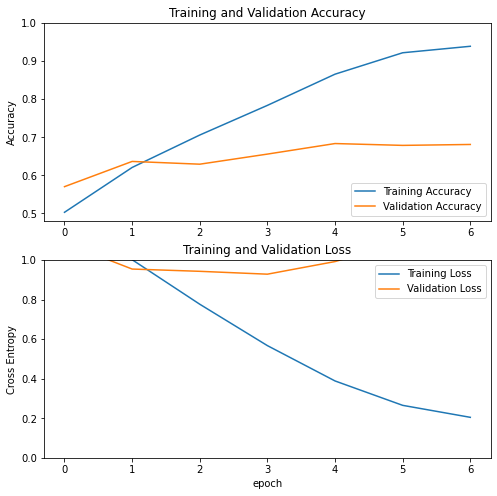

In [86]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [73]:
loaded_model = load_model('multi_model_5.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

53/53 [==============================] - 21s 393ms/step - loss: 0.8860 - acc: 0.5948

 테스트 정확도: 0.5948


In [74]:
loaded_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 512)         9347072   
_________________________________________________________________
dropout_12 (Dropout)         (None, None, 512)         0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 256)         655616    
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 4)                

In [75]:
y_pred = np.argmax(loaded_model.predict(X_test), axis=-1)

In [76]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score
confusion_matrix(y_test, y_pred)

array([[712,  23,  53,  36],
       [ 84,  46,  27,  17],
       [120,  13, 331,  20],
       [ 88,   3,  25,  90]], dtype=int64)

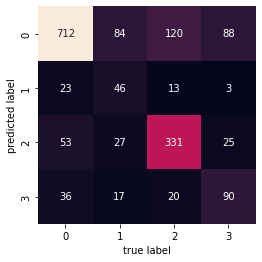

In [77]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [78]:
precision = precision_score(y_test, y_pred, average = 'weighted')
precision

0.687024882554938

In [79]:
recall = recall_score(y_test, y_pred, average = 'weighted')
recall

0.6984597156398105

In [80]:
f1score = f1_score(y_test, y_pred, average= 'weighted')
f1score

0.6827339518436125

In [81]:
new_songs = '''
어느새 빗물이 내 발목에 고이고
참았던 눈물이 내 눈가에 고이고
I cry
어딜 가도 떠있는 내 작은 먹구름
까치발 딛고 잡아보려고 해도
키가 닿지 않아 항상 손끝 위에
어느새 빗물이 내 발목에 고이고
참았던 눈물이 내 눈가에 고이고
I cry
그대는 내 머리 위에 우산
어깨 위에 차가운 비 내리는 밤
내 곁에 그대가 습관이 돼버린 나
난 그대 없이는 안돼요
alone in the rain
어딜 가도 내 뒤를 쫓는 나만의 먹구름
창문을 닫고 끝내 눈을 감아도
곧 나를 깨우는 차가운 한방울
어느새 빗물이 내 발목에 고이고
참았던 눈물이 내 눈가에 고이고
I cry
그대는 내 머리 위에 우산
어깨 위에 차가운 비 내리는 밤
내 곁에 그대가 습관이 돼버린 나
난 그대 없이는 안돼요
alone in the rain
나의 곁에 그대가 없기에
내 창밖에 우산을 들고 기다리던 그대
I cry
그대는 내 머리 위에 우산
어깨 위에 차가운 비 내리는 밤
내 곁에 그대가 습관이 돼버린 나
난 그대 없이는 안돼요
I need you back in my life
그대는 내 머리 위에 우산
어깨 위에 차가운 비 내리는 밤
내 곁에 그대가 없는 반쪽의 세상
그댄 나 없이는 안돼요
'''

In [84]:
import re
new_songs = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_songs)
new_song_token = okt.morphs(new_songs) # 토큰화
new_encoded = tokenizer.texts_to_sequences([new_song_token]) # 인코딩
new_pad = pad_sequences(new_encoded, maxlen = 700) # 패딩
new_pred = np.argmax(loaded_model.predict(new_pad), axis=-1) # 감정 분류
new_pred

array([0], dtype=int64)

In [85]:
new_pred = loaded_model.predict(new_pad)
new_pred

array([[0.9217256 , 0.04844766, 0.01409812, 0.01572868]], dtype=float32)